In [4]:
import pandas as pd
from sqlalchemy import create_engine

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sktime.forecasting.model_selection import temporal_train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sktime.utils.plotting import plot_series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os import getenv
from dotenv import load_dotenv

load_dotenv(".env")
PASSWORD = getenv("PASSWORD")



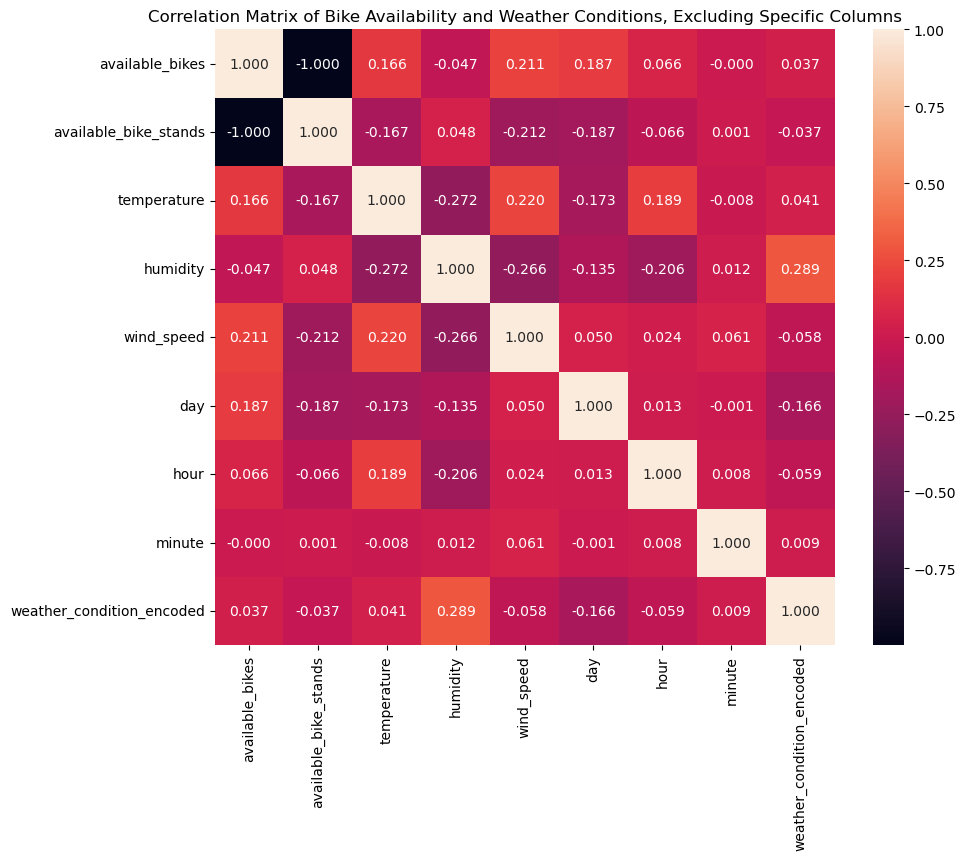

In [5]:
# Database connection parameters

host_name='localhost'
username='root'
password=PASSWORD
database_name="dublinbikes"

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host_name}/{database_name}')
#query = "SELECT last_update AS ds, available_bikes AS y FROM availability WHERE station_id=1"

query = """
SELECT S.station_id, S.bike_stands, A.last_update, A.available_bikes, A.available_bike_stands, W.temperature, W.humidity, W.weather_condition, W.wind_speed
FROM station S, availability A, weather_data W
WHERE S.station_id = A.station_id AND A.station_id = W.station_id AND W.last_update = A.last_update AND A.station_id = 1; 
"""


# Execute the query and load the data into a DataFrame
df = pd.read_sql(query, engine)

# Convert 'last_update' from UNIX time in milliseconds to datetime
df['last_update'] = pd.to_datetime(df['last_update'], unit='ms')


# Extract date, day (of the week), hour, and minute
df['date'] = df['last_update'].dt.date
df['day'] = df['last_update'].dt.dayofweek  # Monday=0, Sunday=6
df['hour'] = df['last_update'].dt.hour
df['minute'] = df['last_update'].dt.minute
# Convert temperature from Kelvin to Celsius
df['temperature'] = df['temperature'] - 273.15

# This will map each unique string to a number
df['weather_condition_encoded'], unique = pd.factorize(df['weather_condition'])


# Reset the index
df.reset_index(drop=True, inplace=True)

# Exclude 'station_id' and 'bike_stands' by not listing them here
columns_for_corr = [col for col in df.columns if col not in ('station_id', 'bike_stands', 'date', 'last_update','weather_condition')]

# Ensure we're only including numeric columns for the correlation matrix
# This also excludes 'station_id' and 'bike_stands' implicitly if they were numeric
numeric_df_for_corr = df[columns_for_corr].select_dtypes(include=[np.number])

# Calculate the correlation matrix for the selected columns
corr_matrix = numeric_df_for_corr.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f")
plt.title('Correlation Matrix of Bike Availability and Weather Conditions, Excluding Specific Columns')
plt.show()





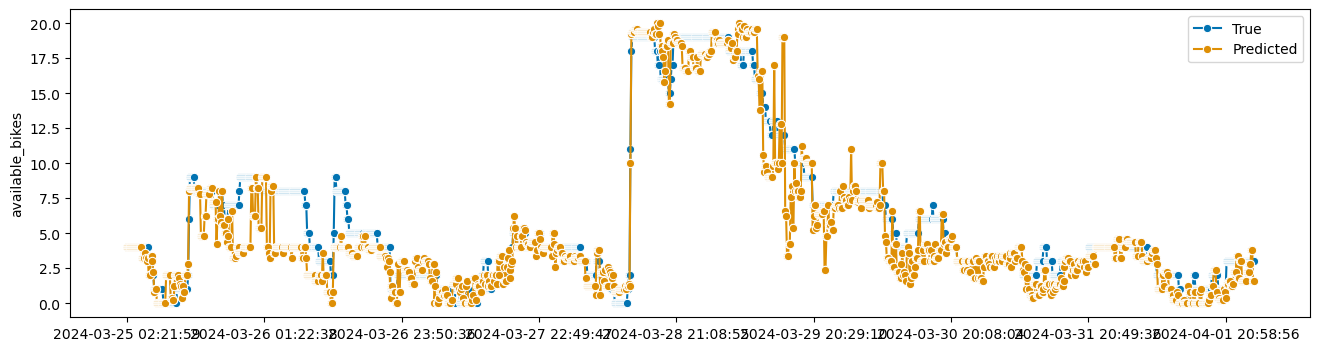

In [10]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from os import getenv
from dotenv import load_dotenv
# Database connection parameters
load_dotenv(".env")
PASSWORD = getenv("PASSWORD")

host_name = 'localhost'
username = 'root'
password = PASSWORD 
database_name = "dublinbikes"

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host_name}/{database_name}')

# SQL query
query = """
SELECT S.station_id, S.bike_stands, A.last_update, A.available_bikes, A.available_bike_stands,
       W.temperature, W.humidity, W.weather_condition, W.wind_speed
FROM station S
JOIN availability A ON S.station_id = A.station_id
JOIN weather_data W ON A.station_id = W.station_id AND W.last_update = A.last_update
WHERE S.station_id = 105;
"""

# Execute the query and load the data into a DataFrame
df = pd.read_sql(query, engine)

# Convert 'last_update' from UNIX time in milliseconds to datetime and set as index
df['last_update'] = pd.to_datetime(df['last_update'], unit='ms')
df.set_index('last_update', inplace=True)

# Convert temperature from Kelvin to Celsius
df['temperature'] = df['temperature'] - 273.15

# Factorize the 'weather_condition' to turn it into a numeric variable
df['weather_condition_encoded'] = pd.factorize(df['weather_condition'])[0]

# Drop non-predictive columns and the target column to define features
X = df.drop(['available_bikes', 'station_id', 'bike_stands', 'weather_condition'], axis=1)

# Define the target variable
y = df['available_bikes']

# Temporal train-test split
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize KNN Regressor from sklearn
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Fit the KNN Regressor
knn_regressor.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn_regressor.predict(X_test_scaled)

# Plot the true vs predicted values
plot_series(y_test, pd.Series(y_pred, index=y_test.index), labels=["True", "Predicted"])
plt.show()


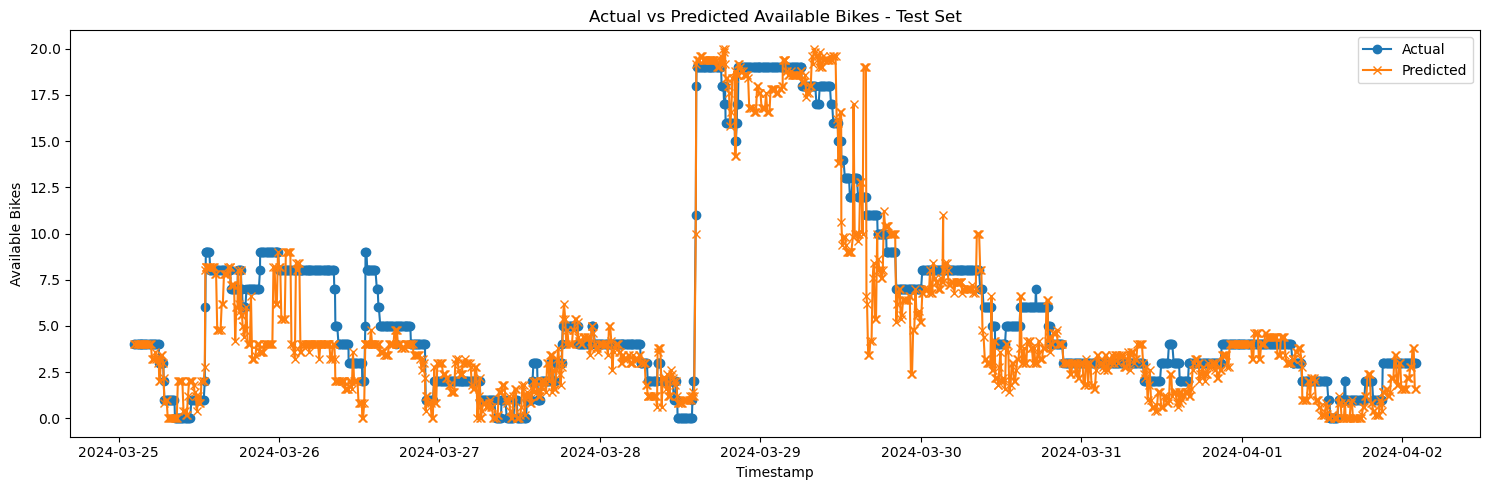

In [11]:
# Plot the test data and predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')

plt.title('Actual vs Predicted Available Bikes - Test Set')
plt.xlabel('Timestamp')
plt.ylabel('Available Bikes')
plt.legend()
plt.tight_layout()
plt.show()

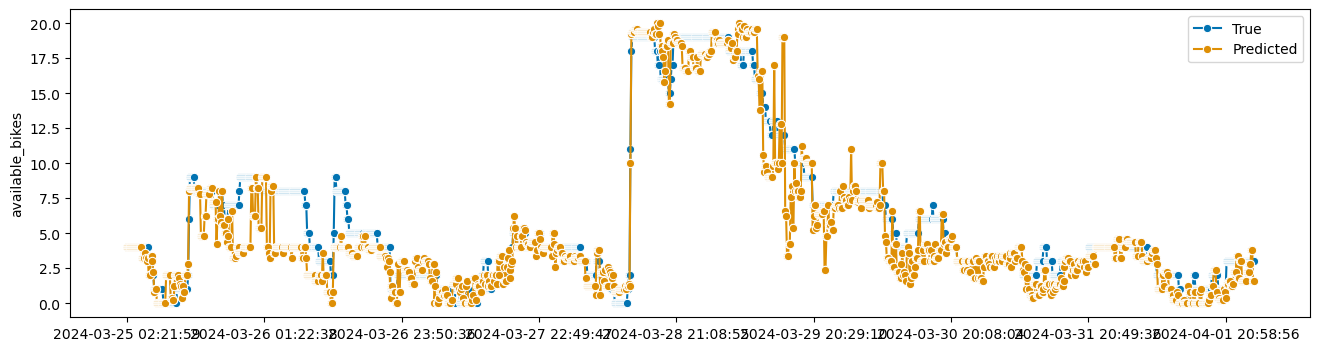

In [6]:
import pandas as pd
from sqlalchemy import create_engine
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from os import getenv
from dotenv import load_dotenv
# Database connection parameters
load_dotenv(".env")
PASSWORD = getenv("PASSWORD")

host_name = 'localhost'
username = 'root'
password = PASSWORD 
database_name = "dublinbikes"

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host_name}/{database_name}')

# SQL query
query = """
SELECT S.station_id, S.bike_stands, A.last_update, A.available_bikes, A.available_bike_stands,
       W.temperature, W.humidity, W.weather_condition, W.wind_speed
FROM station S
JOIN availability A ON S.station_id = A.station_id
JOIN weather_data W ON A.station_id = W.station_id AND W.last_update = A.last_update
WHERE S.station_id = 105;
"""

# Execute the query and load the data into a DataFrame
df = pd.read_sql(query, engine)

# Convert 'last_update' from UNIX time in milliseconds to datetime and set as index
df['last_update'] = pd.to_datetime(df['last_update'], unit='ms')
df.set_index('last_update', inplace=True)

# Convert temperature from Kelvin to Celsius
df['temperature'] = df['temperature'] - 273.15

# Factorize the 'weather_condition' to turn it into a numeric variable
df['weather_condition_encoded'] = pd.factorize(df['weather_condition'])[0]

# Drop non-predictive columns and the target column to define features
X = df.drop(['available_bikes', 'station_id', 'bike_stands', 'weather_condition'], axis=1)

# Define the target variable
y = df['available_bikes']

# Temporal train-test split
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize KNN Regressor from sklearn
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Fit the KNN Regressor
knn_regressor.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = knn_regressor.predict(X_test_scaled)

# Plot the true vs predicted values
plot_series(y_test, pd.Series(y_pred, index=y_test.index), labels=["True", "Predicted"])
plt.show()


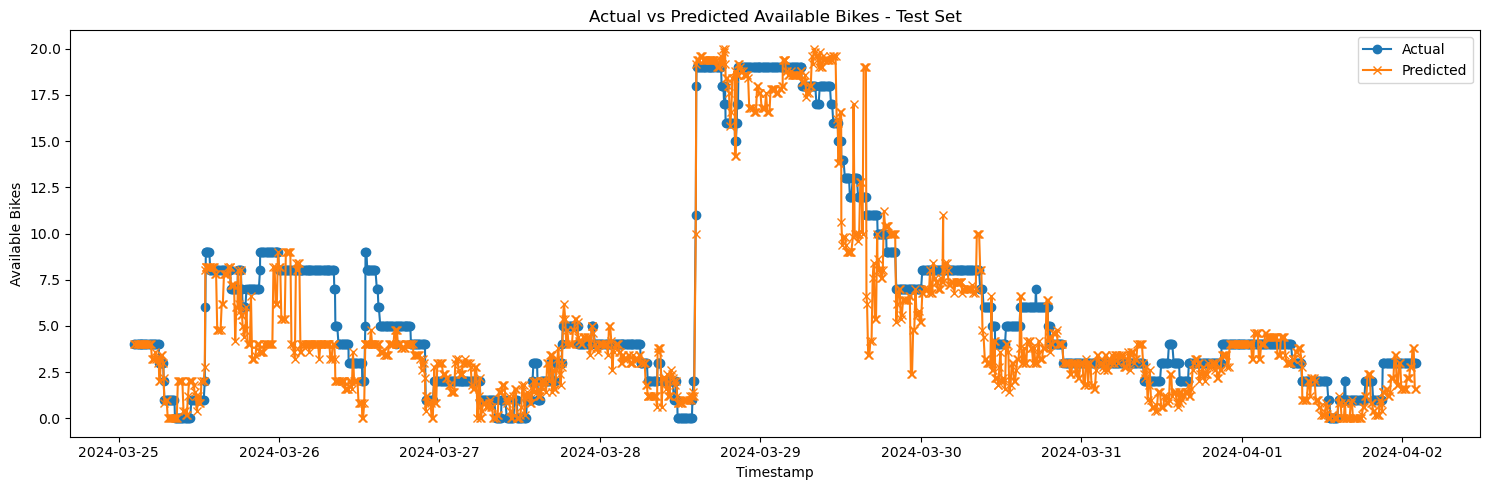

In [7]:
# Plot the test data and predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label='Actual', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted', marker='x')

plt.title('Actual vs Predicted Available Bikes - Test Set')
plt.xlabel('Timestamp')
plt.ylabel('Available Bikes')
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R²): {r2}")

Mean Absolute Error (MAE): 1.1813311688311685
Mean Squared Error (MSE): 2.928538961038961
Root Mean Squared Error (RMSE): 1.7112974496092024
R-squared (R²): 0.8929715286878729


In [9]:
# Define a threshold for acceptable error
threshold = 2  # This means predictions within 5 bikes of the actual value are considered "accurate"

# Calculate the percentage of predictions within the threshold
accuracy_within_threshold = np.mean(np.abs(y_test - y_pred) <= threshold) * 100
print(f"Percentage of predictions within ±{threshold} bikes: {accuracy_within_threshold}%")


Percentage of predictions within ±2 bikes: 82.79220779220779%
